### Lecture 1, step 2: Using Essentia-standard for computing the features

In this version, we demonstrate use of Essentia for some basic operations file reading, framing/windowing,spectrum estimation, etc. and reading/writing data to pickle files. 

This notebook replicates that of Lecture 1 - step 1 using Essentia. We also plot the features and discuss their characteristics together with audio.

This notebook does not have student version.

In [1]:
import os
import sys
import pickle
import numpy as np
import essentia.standard as ess
import matplotlib.pyplot as plt

%matplotlib inline

#Container for analysis parameters
class AnalysisParams:
    def __init__(self,windowSize,hopSize,windowFunction,fftN):
        '''
        windowSize: milliseconds,
        hopSize: milliseconds,
        windowFunction: str ('blackman','hanning',...)
        fftN: int
        '''
        self.windowSize = windowSize
        self.hopSize = hopSize
        self.windowFunction = windowFunction
        self.fftN=fftN

def initiateData4File(file,root):
    '''Forming the data structure for file
    Parameters
    ----------
    file,root : str
        File name and path info
    
    Returns
    -------
    fileData : dict
        Dictionary containing all info and data for the file
    ''' 
    fileData=dict();fileData['name']=file;fileData['path']=root;
    #Low level(LL) features
    fileData['NRG']=[];fileData['zcr']=[];#time domain features
    fileData['specCentroid']=[];fileData['specFlatness']=[];#frequency domain features
    
    return fileData
def computeLLFeatures(fileData,params):
    '''Computation of the low-level features
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    Modifies
    -------
    fileData 
    '''
    #Reading the wave file
    fs=44100
    x = ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate = fs)()

    #Windowing (first converting from msec to number of samples)
    windowSize=round(fs*params.windowSize/1000);windowSize=int(windowSize/2)*2#assuring window size is even
    hopSize=round(fs*params.hopSize/1000);hopSize=int(hopSize/2)*2#assuring hopSize is even

    #Initializing lists for features
    NRG = [];zcr = [];specCentroid = [];specFlatness = []
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize=windowSize, hopSize=hopSize, startFromZero=True):
        frame=ess.Windowing(size=windowSize, type=params.windowFunction)(frame)
        NRG.append(ess.Energy()(frame))
        zcr.append(ess.ZeroCrossingRate()(frame))
        specCentroid.append(ess.SpectralCentroidTime()(frame))#spectral centroid computation from time-domain signal 
        specFlatness.append(ess.Flatness()(ess.Spectrum(size=params.fftN)(frame)))

    #Scaling features for simplicity of plotting together
    specFlatness=specFlatness/(np.max(np.abs(specFlatness)))
    NRG=NRG/(np.max(np.abs(NRG)))
    zcr=zcr/(np.max(np.abs(zcr)))
    specCentroid=specCentroid/(np.max(np.abs(specCentroid)))
    
    fileData['NRG']=np.array(NRG);
    fileData['zcr']=np.array(zcr);
    fileData['specCentroid']=np.array(specCentroid);
    fileData['specFlatness']=np.array(specFlatness);

def computeGlobFeatures(fileData,NRGthreshold=0.05):
    '''Computation of the global features from low-level features
    An energy threshold (NRGthres*maxEnergy) is applied to exclude features from silence regions

    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    NRGthresPerc: float
        Energy threshold defined as ratio to maximum energy. Ex: 0.05 corresponds to 5%
    Modifies
    -------
    fileData 
    '''
    #To remove from feature data those coming from silence regions, let's use an energy threshold (%5 of the max) 
    NRG=fileData['NRG']
    keepIndexes=NRG<(np.max(NRG)*NRGthreshold)
    
    features=list(fileData.keys())
    features.remove('path');features.remove('name')
    for feature in features:
        data=np.array(fileData[feature][keepIndexes])
        fileData['std_'+feature]=np.std(data)
        fileData['mean_'+feature]=np.mean(data)
        
print('Functions loaded')

Functions loaded


Running feature extraction, saving to file and reading from file

In [2]:
#Setting analysis parameters
# windowSize: milliseconds,hopSize: milliseconds,windowFunction: str ('blackman','hanning',...),fftN: int
params=AnalysisParams(30,10,'hann',2048)
soundsDir='../data/freesound/'

#Gathering all wave files in a folder(including subfolders)
instFiles=dict()#dictionary containing for each instrument a list that carries dictionaries
for root, dirs, files in os.walk(soundsDir):
    for file in files:
        if file.endswith('.wav'):
            instrument=file.split('_')[0]
            fileData=initiateData4File(file,root)            
            files4instrument=instFiles.get(instrument)
            if files4instrument==None:
                files4instrument=[fileData]
            else:
                files4instrument.append(fileData)
            instFiles[instrument]=files4instrument

#Feature extraction for all files of each instrument
for instrument, filesData in instFiles.items():
    for fileInd in range(len(filesData)):
        computeLLFeatures(instFiles[instrument][fileInd],params)
        computeGlobFeatures(instFiles[instrument][fileInd])

#Saving all results in a pickle file
pickleProtocol=1#choosen for backward compatibility
with open(soundsDir+'extractedfeatures.pkl' , 'wb') as f:
    pickle.dump(instFiles, f, pickleProtocol)

#Let's clear data and re-read it
instFiles=None
print('Features extracted and saved in a file')

Features extracted and saved in a file


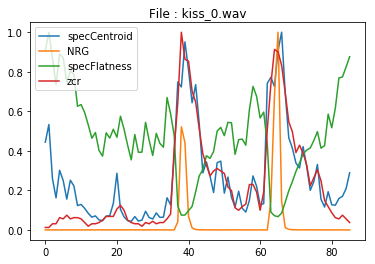

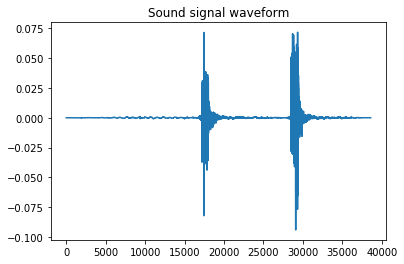

In [3]:
#Reading the data
with open(soundsDir+'extractedfeatures.pkl', 'rb') as f:
    instFiles=pickle.load(f)

#Let's print an example
fileInd=0;instrument='kiss';
plt.title('File : '+instFiles[instrument][fileInd]['name'])
plt.plot(instFiles[instrument][fileInd]['specCentroid'],label='specCentroid')
plt.plot(instFiles[instrument][fileInd]['NRG'],label='NRG')
plt.plot(instFiles[instrument][fileInd]['specFlatness'],label='specFlatness')
plt.plot(instFiles[instrument][fileInd]['zcr'],label='zcr')
plt.legend(loc='best')
plt.show()
x = ess.MonoLoader(filename = os.path.join(instFiles[instrument][fileInd]['path'], instFiles[instrument][fileInd]['name']), sampleRate = 44100)()
plt.plot(x)
plt.title('Sound signal waveform')
plt.show()